# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# **Install**

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.0 MB/s 


# **Imports 📢**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

In [ ]:
torch.__version__

'1.12.1+cu113'

# **Dataset 🗂️**

## Load dataset

In [ ]:
!cp '/content/drive/MyDrive/deep-learning-2022-howsam/session-6-rnn/UCI HAR Dataset.zip' /content/

In [ ]:
!unzip /content/UCI\ HAR\ Dataset.zip

In [ ]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [ ]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [ ]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [ ]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [ ]:
y_train, y_test

(tensor([4, 4, 4,  ..., 1, 1, 1]), tensor([4, 4, 4,  ..., 1, 1, 1]))

In [ ]:
torch.unique(y_test)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [ ]:
train_set, test_set = random_split(train_set, (5000, x_train.shape[0]-5000))

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([64, 128, 9])
torch.Size([64])


## Visulaize

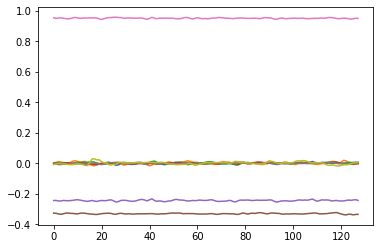

In [ ]:
plt.plot(x[0])

# **Model 🧠**

In [ ]:
model = nn.RNN(input_size=9, hidden_size=32, num_layers=4,
       nonlinearity='tanh', bias=True, batch_first=True, dropout=0.,
       bidirectional=True)

In [ ]:
model.parameters()
model.weight_hh_l0

Parameter containing:
tensor([[ 0.0225, -0.1041,  0.0191,  ...,  0.1396,  0.0414, -0.1395],
        [-0.0579, -0.0686,  0.1676,  ..., -0.1166, -0.0717, -0.0844],
        [-0.0424, -0.0599, -0.1269,  ..., -0.1727, -0.0603, -0.0410],
        ...,
        [ 0.1258,  0.1710,  0.1646,  ...,  0.0564,  0.0276,  0.1019],
        [ 0.1357,  0.1013,  0.1413,  ...,  0.1591, -0.1540,  0.0537],
        [-0.0244,  0.1551, -0.0570,  ...,  0.0763, -0.1582,  0.1554]],
       requires_grad=True)

In [ ]:
outputs, hn = model(x)

In [ ]:
hn.shape

torch.Size([8, 64, 32])

In [ ]:
outputs.shape

torch.Size([64, 128, 32])

In [ ]:
print(outputs[0, -1])
print(hn[0, 0])

tensor([ 0.2724,  0.2118, -0.1106,  0.3287, -0.2012, -0.0943,  0.1618, -0.0289,
        -0.1722, -0.0290, -0.0455, -0.0780,  0.1671, -0.1604,  0.4012, -0.0396,
         0.0622, -0.1166, -0.0662,  0.1319,  0.1250,  0.1033,  0.2139, -0.1565,
        -0.1988,  0.0355, -0.2851,  0.0419,  0.3349, -0.1246,  0.2685,  0.2193],
       grad_fn=<SelectBackward0>)
tensor([ 0.2724,  0.2118, -0.1106,  0.3287, -0.2012, -0.0943,  0.1618, -0.0289,
        -0.1722, -0.0290, -0.0455, -0.0780,  0.1671, -0.1604,  0.4012, -0.0396,
         0.0622, -0.1166, -0.0662,  0.1319,  0.1250,  0.1033,  0.2139, -0.1565,
        -0.1988,  0.0355, -0.2851,  0.0419,  0.3349, -0.1246,  0.2685,  0.2193],
       grad_fn=<SelectBackward0>)


In [ ]:
outputs, hn = model(x, torch.zeros(8, 64, 32))

In [ ]:
outputs.shape

torch.Size([64, 128, 64])

In [ ]:
outputs[:, -1].shape

torch.Size([64, 64])

In [ ]:
model = nn.Sequential(nn.RNN(input_size=9, hidden_size=32, num_layers=4,
                             nonlinearity='tanh', bias=True, batch_first=True, dropout=0.,
                             bidirectional=True),
                      nn.Linear(64, 6))

In [ ]:
model(x)

## Newwwww!

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, ):
    super().__init__()
    pass

  def forward(self, x):
    return y

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, ):
    super().__init__()
    self.fc1 = nn.Linear(4, 32)
    self.bn1 = nn.BatchNorm1d(32)
    self.fc2 = nn.Linear(32, 1)

  def forward(self, x):
    y = torch.relu(self.bn1(self.fc1(x)))
    y = self.fc2(y)
    y = torch.sigmoid(y)
    return y

In [ ]:
model = RNNModel()
model

RNNModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
model(torch.randn(3, 4))

tensor([[0.5919],
        [0.4445],
        [0.4703]], grad_fn=<SigmoidBackward0>)

In [ ]:
nn.Module()

Module()

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, ):
    super().__init__()
    self.fc1 = nn.Linear(4, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(32, 64)

  def forward(self, x):
    y1 = self.fc1(x)
    y2 = self.fc2(y1)
    y3 = self.fc3(y1)
    y = y2 + y3
    return y, y1

In [ ]:
model = RNNModel()
model

RNNModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
)

In [ ]:
a, b = model(torch.randn(3, 4))
a.shape, b.shape

(torch.Size([3, 64]), torch.Size([3, 32]))

## RNN

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = nn.RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)
    # hidden_size = hidden_size * 2 if bidirectional else hidden_size
    # self.fc = nn.Linear(hidden_size, num_cls)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    # print(outputs.shape, hn.shape)
    # y = self.fc(outputs[:, -1]) # out: one
    # outputs = outputs.flatten(1)
    y = self.fc(outputs) # out: many
    y = y.mean(dim=1)
    return y

In [ ]:
model = RNNModel(9, 32, 1, False, 6)
model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNNModel(
  (rnn): RNN(9, 32, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [ ]:
model(torch.randn(2, 128, 9)).shape

torch.Size([2, 6])

In [ ]:
model.fc.weight.shape

torch.Size([6, 32])

In [ ]:
model(x).shape

torch.Size([64, 6])

In [ ]:
model.parameters()

<generator object Module.parameters at 0x7f1f357b4f50>

In [ ]:
optimizer = optim.Adam(model.parameters())

## Params

In [ ]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [ ]:
num_params(model, 1e3)

1.574

# **Device ⚙️**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# **Utils 🧰**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy().to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [ ]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.7989, grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

C:\Users\PC\anaconda3\envs\howsam-deep\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 104.27batch/s, accuracy=86.6, loss=0.455]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')
  model = RNNModel(9, 32, 4, False, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 15.22batch/s, accuracy=37.4, loss=2.48]



LR=0.5


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 14.95batch/s, accuracy=37.3, loss=1.55]



LR=0.2


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 15.07batch/s, accuracy=89.2, loss=0.34]



LR=0.1


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 15.02batch/s, accuracy=88.6, loss=0.316]



LR=0.01


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 14.81batch/s, accuracy=59.6, loss=0.944]



LR=0.001


Epoch 4: 100%|██████████| 115/115 [00:07<00:00, 15.05batch/s, accuracy=39, loss=1.37]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(9, 128, 1, True, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [ ]:
model = RNNModel(9, 32, 4, False, 6).to(device)

In [ ]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 79/79 [00:05<00:00, 15.05batch/s, accuracy=32.2, loss=1.53]


Valid: Loss = 1.339, Acc = 0.3414



Epoch 1: 100%|██████████| 79/79 [00:06<00:00, 11.81batch/s, accuracy=41.8, loss=1.32]


Valid: Loss = 1.097, Acc = 0.4809



Epoch 2: 100%|██████████| 79/79 [00:05<00:00, 15.19batch/s, accuracy=53.9, loss=1.13]


Valid: Loss = 0.8032, Acc = 0.6352



Epoch 3: 100%|██████████| 79/79 [00:05<00:00, 14.77batch/s, accuracy=63.7, loss=0.899]


Valid: Loss = 0.7035, Acc = 0.5519



Epoch 4: 100%|██████████| 79/79 [00:05<00:00, 15.18batch/s, accuracy=65.5, loss=1.03]


Valid: Loss = 0.9089, Acc = 0.4804



Epoch 5: 100%|██████████| 79/79 [00:05<00:00, 15.21batch/s, accuracy=79.6, loss=0.62]


Valid: Loss = 0.4143, Acc = 0.869



Epoch 6: 100%|██████████| 79/79 [00:05<00:00, 15.09batch/s, accuracy=82.1, loss=0.569]


Valid: Loss = 1.114, Acc = 0.7653



Epoch 7: 100%|██████████| 79/79 [00:05<00:00, 15.03batch/s, accuracy=86, loss=0.439]


Valid: Loss = 0.4575, Acc = 0.8554



Epoch 8: 100%|██████████| 79/79 [00:05<00:00, 15.11batch/s, accuracy=86.9, loss=0.392]


Valid: Loss = 0.568, Acc = 0.7704



Epoch 9: 100%|██████████| 79/79 [00:05<00:00, 15.30batch/s, accuracy=88.2, loss=0.448]


Valid: Loss = 0.6388, Acc = 0.7164



## Debug

In [ ]:
with torch.no_grad():
  yp = model(train_set.dataset.tensors[0])
  print((yp.argmax(dim=1) == y_train).sum())

In [ ]:
test_set = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)
with torch.no_grad():
  yp = model(test_set.tensors[0])
  print((yp.argmax(dim=1) == y_test).sum())

tensor(111)


In [ ]:
yp, yp.argmax(dim=1).unique(), (yp.argmax(dim=1) == 5).sum()

(tensor([[-2.9889, -1.6670,  6.3823, -2.3654, -7.5674, 10.1449],
         [-2.9867, -1.6417,  6.3843, -2.3867, -7.5678, 10.1330],
         [-2.9869, -1.6260,  6.3837, -2.3994, -7.5675, 10.1279],
         ...,
         [-2.9525, -1.4453,  6.4369, -2.5618, -7.5876, 10.0198],
         [-2.9579, -1.3969,  6.4219, -2.5962, -7.5806, 10.0092],
         [-2.9580, -1.4164,  6.4295, -2.5838, -7.5857, 10.0183]]),
 tensor([1, 2, 3, 4, 5]),
 tensor(2502))

In [ ]:
x_test[0], x_test[100]

(tensor([[ 1.0412, -0.0294,  0.4375,  ..., -0.2698,  0.0117,  0.1068],
         [ 1.0418, -0.0397,  0.4683,  ..., -0.2800,  0.0131,  0.1525],
         [ 1.0391, -0.0524,  0.4983,  ..., -0.2927,  0.0113,  0.2168],
         ...,
         [ 0.9930,  0.0117, -0.0051,  ..., -0.2600,  0.0013,  0.0037],
         [ 0.9932,  0.0095, -0.0204,  ..., -0.2621,  0.0015,  0.0040],
         [ 0.9944,  0.0073, -0.0300,  ..., -0.2641,  0.0026,  0.0049]]),
 tensor([[ 0.9057, -0.1842,  0.4645,  ..., -0.5164, -0.0819, -0.0589],
         [ 0.8388, -0.1049,  0.5207,  ..., -0.4373, -0.1489, -0.0458],
         [ 0.7889, -0.0401,  0.4872,  ..., -0.3727, -0.1988, -0.0413],
         ...,
         [ 1.0765,  0.1580,  0.1119,  ..., -0.1721,  0.0872,  0.0252],
         [ 1.0244,  0.1704,  0.0200,  ..., -0.1598,  0.0352,  0.0759],
         [ 1.0337,  0.1284,  0.0018,  ..., -0.2019,  0.0445,  0.1028]]))

# **Plot**

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()